In [1]:
import numpy as np
import torch

In [2]:
import sys
sys.path.append('E:/Projects/XAI/BHEM')
sys.path.append('/run/media/xiangyu/Data/Projects/XAI/BHEM')

from model.explanation.shap_exp import ShapExp
from matplotlib import pyplot as plt
from model import Cnn, getClassifier
from dataset import handwriting
from utils import reconstruct_mask, basic_segment

from aopc import aopc

/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load model and MNIST dataset

In [3]:
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cnn = getClassifier(Cnn, device, f_params='../MINST.pkl')

mnist = handwriting('mnist_784', normalize=True)

# Load AOPC

In [4]:
AOPCs = aopc(cnn.predict_proba)

# Test the AOPC on single image

In [5]:
img_ID = 0
Image = torch.from_numpy(mnist.XCnn[img_ID]).unsqueeze(0)
y = mnist.y[img_ID]

basic_seg = basic_segment(Image)
shap_exp = ShapExp(cnn.predict_proba, Image, masker=basic_seg.get_mask())
shap_exp_values = shap_exp.shap_values[y, 0, 0, :, :]

print(f"SHAP AOPC on image {img_ID} is {AOPCs.get_single_aopc_value(Image, y, shap_exp_values)}")

SHAP AOPC on image 0 is [0.13413149 0.03467876 0.02302909 0.91210709 0.91210709 0.91210709
 0.91210709 0.91210709 0.91210709 0.91210709]


# Test the AOPC on batched images

In [6]:
shap_aopc = AOPCs.get_average_shap_aopc_value(testnum=50, dataset = mnist)

50 images: 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


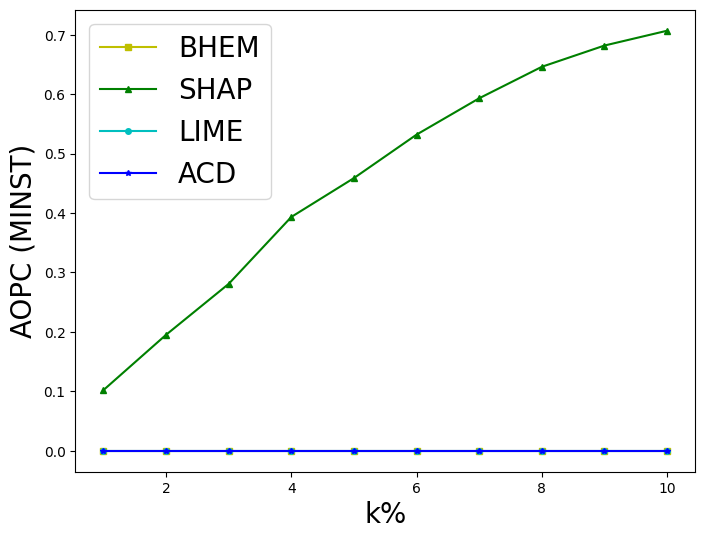

In [7]:
AOPCs.plot_aopc()

In [8]:
# plt.figure(figsize=(8, 6))
# # plt.plot(xaxislabel,Bylabel,'s-',markersize = 4,color = 'y',label="BHEM")
# plt.plot(percents*100,AOPC/testnum,'^-',markersize = 4,color = 'g',label="SHAP")
# # plt.plot(xaxislabel,Lylabel,'o-',markersize = 4,color = 'c',label="LIME")
# plt.ylabel("AOPC (MINST)",fontsize = 20)
# plt.xlabel("k%",fontsize = 20)
# # plt.xlim([5,50])
# # plt.ylim([0.2,1.0])
# plt.legend(prop={'size':20})